# Fraud detection using dummy data

In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter

labels = ['no fraud', 'fraud']

# Creat dummy data

In [47]:
n = 15
X, y = make_classification(n_samples=15000,
                           n_features=n,
                           n_informative=3,
                           n_classes=2,
                           weights=[0.5,0.5],
                           random_state= 0)

In [48]:
print(X.shape, y.shape)
print(Counter(y))

(15000, 15) (15000,)
Counter({1: 7510, 0: 7490})


In [49]:
col_features = [f'X{i}' for i in range(n)]
df = pd.DataFrame(X, columns=col_features)
df['target'] = y

In [50]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,target
0,-1.585901,-1.072756,1.478527,-0.005682,-0.043057,-0.250278,-0.691237,0.520402,1.689371,-0.701481,1.259567,0.088220,0.695140,0.081269,-0.276898,1
1,-1.848890,-1.132823,-1.381304,-0.906043,0.537159,-0.858295,-0.671335,1.265265,1.204472,-1.455077,-0.944853,0.169091,-0.239211,0.292913,-0.309465,1
2,0.923884,-0.791989,-0.476096,0.904359,-0.378229,1.601919,-1.100789,-2.536191,-0.634102,1.094765,1.022909,-0.587478,1.157923,-1.233275,1.604400,0
3,0.170861,0.683680,0.616888,-0.455075,-0.038200,-1.763319,0.854041,2.866657,1.877822,0.934138,-0.674222,0.550455,-0.634798,1.242117,-0.878364,0
4,0.820191,0.759085,-0.098487,-0.392834,0.216537,1.384917,-0.875455,-1.907433,-0.914748,-1.392811,-1.724091,0.012625,0.984491,-0.442015,-0.789244,0


In [51]:
X_train, X, y_train, y = train_test_split(df[col_features], df['target'], train_size=0.8, stratify=df['target'])
X_val, X_test, y_val, y_test = train_test_split(X, y,train_size=0.5, stratify=y)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(12000, 15) (12000,) (1500, 15) (1500,) (1500, 15) (1500,)


In [52]:
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({1: 6008, 0: 5992})
Counter({1: 751, 0: 749})
Counter({1: 751, 0: 749})


# Model training

In [53]:
arg = {'n_estimators': 1000,
       'num_class':2,
       'objective':'multi:softprob'}
cls = xgboost.XGBClassifier(**arg).fit(X_train,
                                       y_train,
                                       early_stopping_rounds=5,
                                       eval_set=[(X_train, y_train), (X_val, y_val)],
                                       eval_metric=['merror','mlogloss'],
                                       verbose=0)

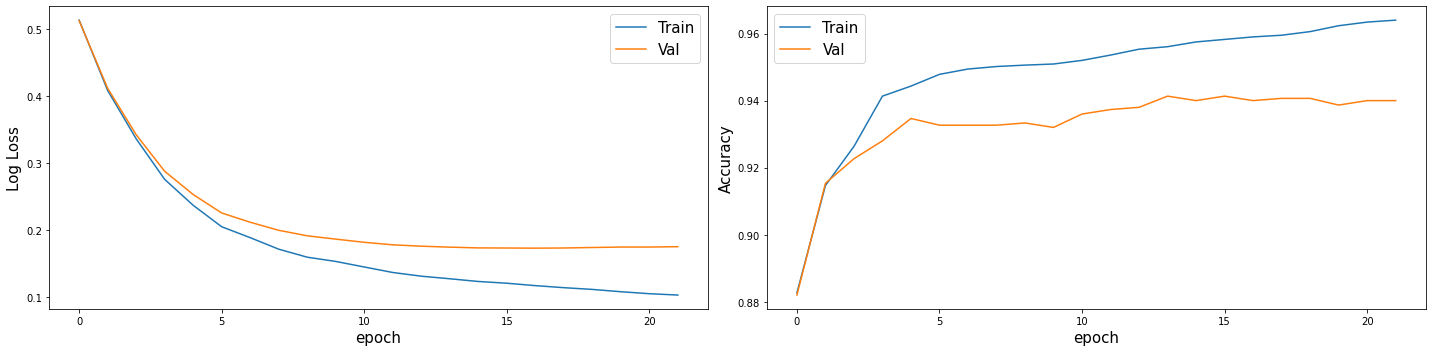

In [54]:
# Training metrics
results = cls.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax1.legend(fontsize=15)
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('Log Loss', fontsize=15)

# Plot classification error
ax2.plot(x_axis, [1-x for x in results['validation_0']['merror']], label='Train')
ax2.plot(x_axis, [1-x for x in results['validation_1']['merror']], label='Val')
ax2.legend(fontsize=15)
ax2.set_xlabel('epoch', fontsize=15)
ax2.set_ylabel('Accuracy', fontsize=15)

plt.tight_layout()

# Evaluation

In [55]:
pred = cls.predict(X_test)

In [56]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

    no fraud       0.91      0.97      0.94       749
       fraud       0.97      0.91      0.94       751

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



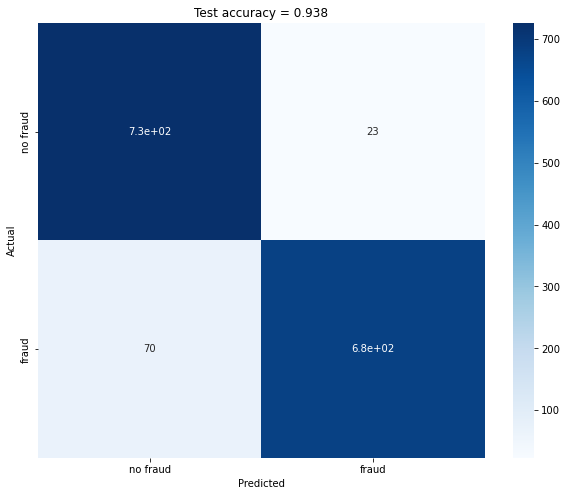

In [57]:
cm = confusion_matrix(y_test, pred)
confusion = pd.DataFrame(cm,columns=labels, index=labels)
confusion.index.name='Actual'
confusion.columns.name='Predicted'

plt.figure(figsize=(10,8))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title(f'Test accuracy = {round(accuracy_score(y_test, pred),3)}')
plt.show()